In [2]:
import joblib
import os
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix
from neuroginius.atlas import Atlas

from cogpred.utils.configuration import get_config
from cogpred.transformers import MatrixMasker
from cogpred.loading import make_training_data
from cogpred.utils.naming import make_run_path

config = get_config()
conn_dir = config["connectivity_matrices"]

ATLAS = "schaefer200"

atlas = Atlas.from_name(ATLAS, soft=False)

k = 3
REFNET = np.unique(atlas.macro_labels)
INTER = REFNET
REFNET = ("Default",)
INTER = ("Default",)

sns.reset_defaults()

In [3]:
matrices, metadata = make_training_data(conn_dir, ATLAS, k, test_centre=None)
run_path = make_run_path(
    config["output_dir"],
    k=k,
    feat="fc",
    atlas=ATLAS,
    net="".join(REFNET),
    inter="".join(INTER)
)

if len(run_path.name) > 55:
    print("too long")
    run_path = make_run_path(
        config["output_dir"],
        k=k,
        feat="fc",
        atlas=ATLAS,
        net="all",
    )
    
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 12 subjects because of lacking MMMSE


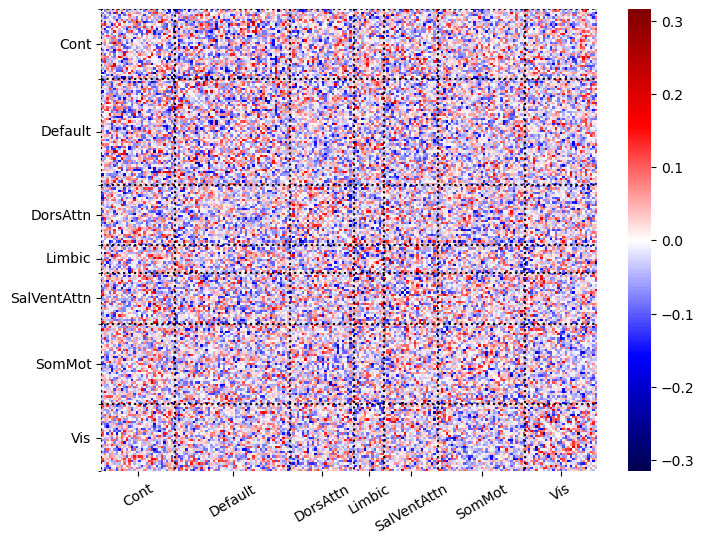

In [4]:
plot_matrix(matrices[10], atlas)
plt.show()

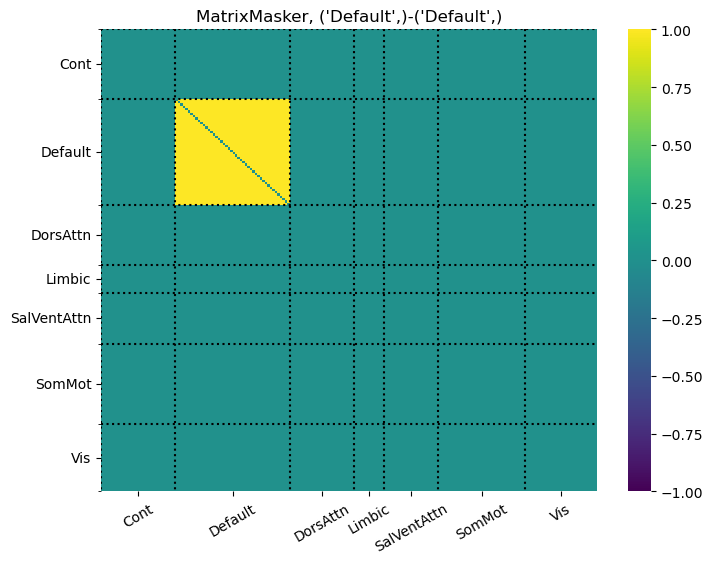

In [5]:
masker = MatrixMasker(REFNET, INTER, atlas=atlas).fit(matrices, metadata)

masker.fit(matrices).plot(cmap="viridis")
plt.show()

In [6]:
from cogpred.supervised import run_cv
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold
from nilearn.connectome import vec_to_sym_matrix
from cogpred.matrices import compute_mat_size

net = SGDClassifier(
        loss="log_loss",
        penalty="l1",
        max_iter=3000,
        random_state=2024,
    )

clf = Pipeline(
    [
    ("matrixmasker", MatrixMasker(REFNET, INTER, atlas=atlas)),
    ("scaler", preprocessing.StandardScaler()),
    ("classifier", net)
    ],
    verbose=False
)


cats = ("stable", "slow", "steep")
outer_cv = GroupKFold(n_splits=8)

test_scores, cm, patterns = run_cv(clf, matrices, metadata, outer_cv)

masker = clf.named_steps["matrixmasker"]
l = len(masker.vec_idx_)
n_regions = compute_mat_size(l)
hmat = vec_to_sym_matrix(
    patterns.transpose((0, 2, 1)), diagonal=np.zeros((outer_cv.n_splits, k, n_regions))
)

              precision    recall  f1-score   support

           0       0.95      0.74      0.83       221
           1       0.11      0.43      0.18        14
           2       0.00      0.00      0.00         3

    accuracy                           0.71       238
   macro avg       0.35      0.39      0.34       238
weighted avg       0.89      0.71      0.78       238

              precision    recall  f1-score   support

           0       0.72      0.75      0.74       101
           1       0.20      0.26      0.23        23
           2       0.00      0.00      0.00        16

    accuracy                           0.59       140
   macro avg       0.31      0.34      0.32       140
weighted avg       0.56      0.59      0.57       140

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       103
           1       0.34      0.40      0.37        25
           2       0.29      0.18      0.22        11

    accuracy        

/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

              precision    recall  f1-score   support

           0       0.83      0.76      0.79       109
           1       0.37      0.35      0.36        31
           2       0.00      0.00      0.00         0

    accuracy                           0.67       140
   macro avg       0.40      0.37      0.38       140
weighted avg       0.73      0.67      0.70       140

              precision    recall  f1-score   support

           0       0.63      0.80      0.71        87
           1       0.36      0.24      0.29        38
           2       0.00      0.00      0.00        15

    accuracy                           0.56       140
   macro avg       0.33      0.35      0.33       140
weighted avg       0.49      0.56      0.52       140

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       110
           1       0.32      0.42      0.37        26
           2       0.11      0.17      0.13         6

    accuracy        

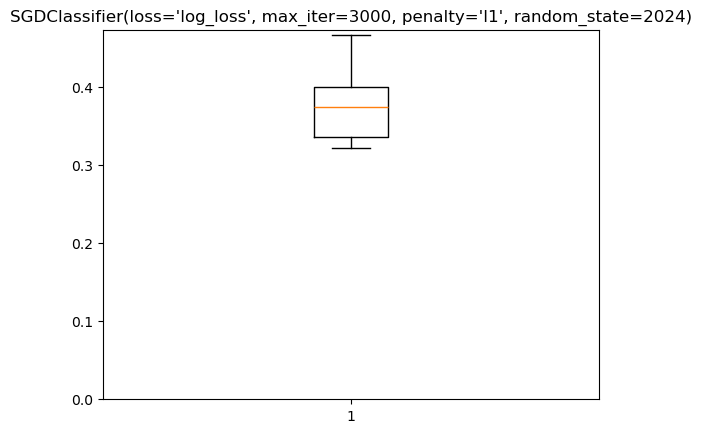

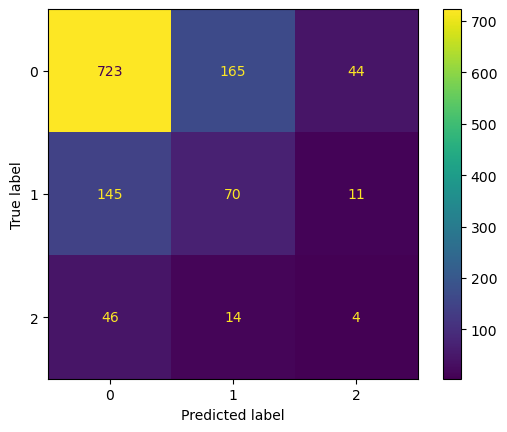

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.boxplot(test_scores)
plt.ylim(0)
plt.title(clf.named_steps["classifier"])
plt.show()

disp = ConfusionMatrixDisplay(cm.astype(int))
disp.plot()
plt.show()

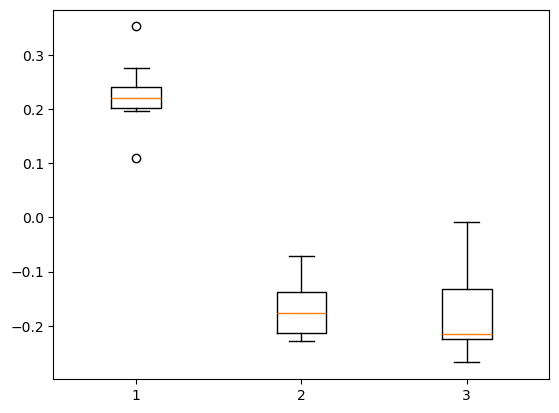

In [8]:
r_stable = hmat[:, 0, ...].mean(axis=(1, 2))
r_slow = hmat[:, 1, ...].mean(axis=(1, 2))
r_steep = hmat[:, 2, ...].mean(axis=(1, 2))
plt.boxplot(
    (
        r_stable,
        r_slow,
        r_steep,
    )
)
plt.show()

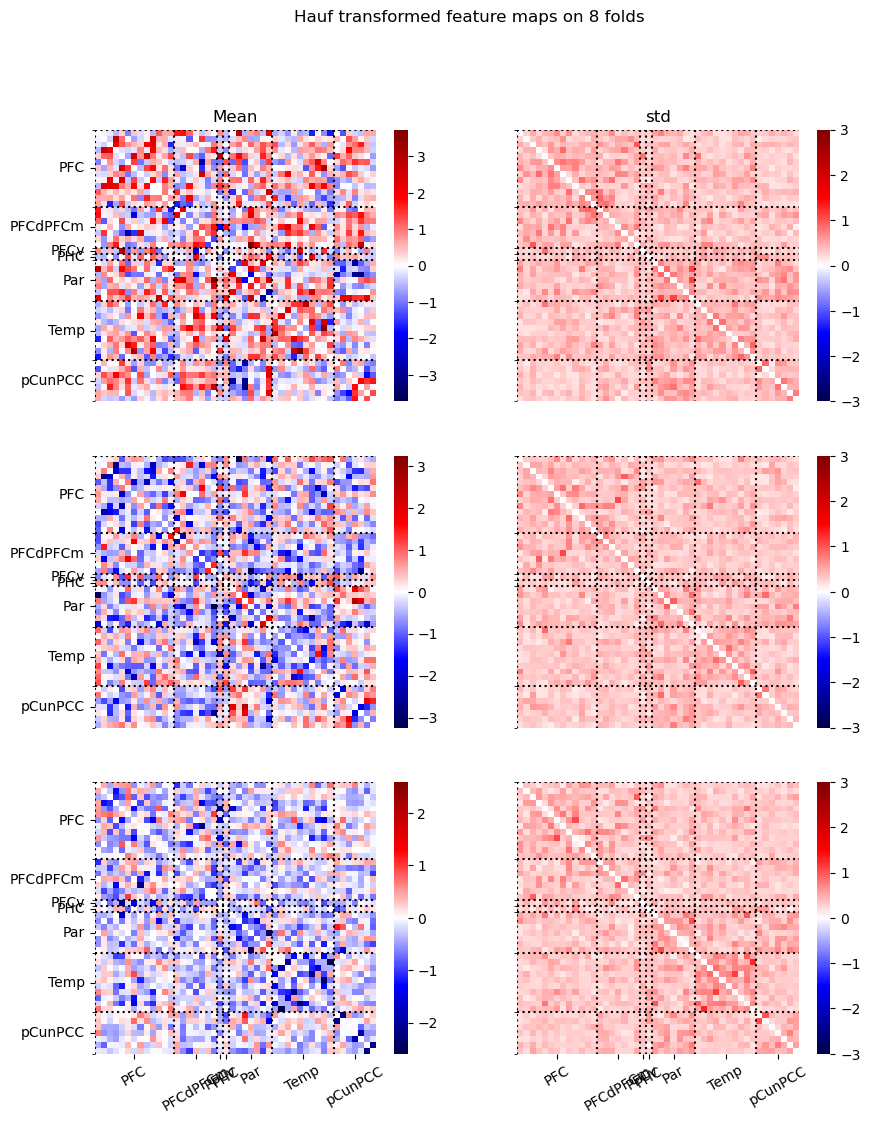

In [9]:
atlas = Atlas.from_name(ATLAS)
def net_select(label):
    if label in masker.refnet or label in masker.interaction:
        return 1
    return 0

regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network in masker.refnet or network in masker.interaction:
        regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
regions = list(np.array(regions).astype(str))

class MockAtlas:
    def __init__(self) -> None:
        self.macro_labels = list(map(self.region_split, regions))

    @staticmethod
    def region_split(label):
        return label.split("_")[-2]
        
if np.all(REFNET == np.unique(atlas.macro_labels)):
    disp_atlas = atlas
else:
    disp_atlas = MockAtlas()


fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for i, cat in enumerate(cats):
    meanmap = np.median(hmat[:, i, ...], axis=0)
    stdmap = np.std(hmat[:, i, ...], axis=0)

    plot_matrix(
        meanmap,
        disp_atlas,
        axes=axes[i, 0],
        #bounds=(-2, 2),
        cmap="seismic",
    )
    plot_matrix(
        stdmap,
        disp_atlas,
        axes=axes[i, 1],
        bounds=(-3, 3),
        cmap="seismic",
    )
    axes[i, 1].set(yticklabels=[])
    axes[i, 1].tick_params(left=False)
    if i < 2:
        axes[i, 0].set(xticklabels=[])
        axes[i, 0].tick_params(bottom=False)
        axes[i, 1].set(xticklabels=[])
        axes[i, 1].tick_params(bottom=False)
        
    
axes[0, 0].set_title("Mean")
axes[0, 1].set_title("std")
fig.suptitle(f"Hauf transformed feature maps on {len(hmat)} folds")
plt.show()

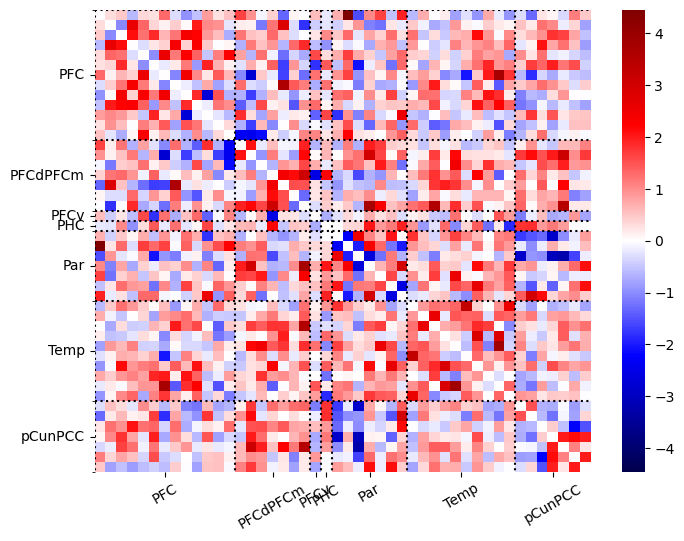

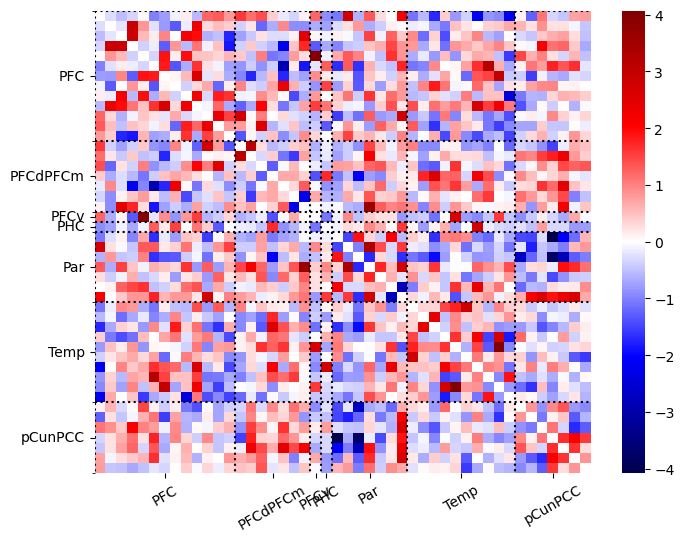

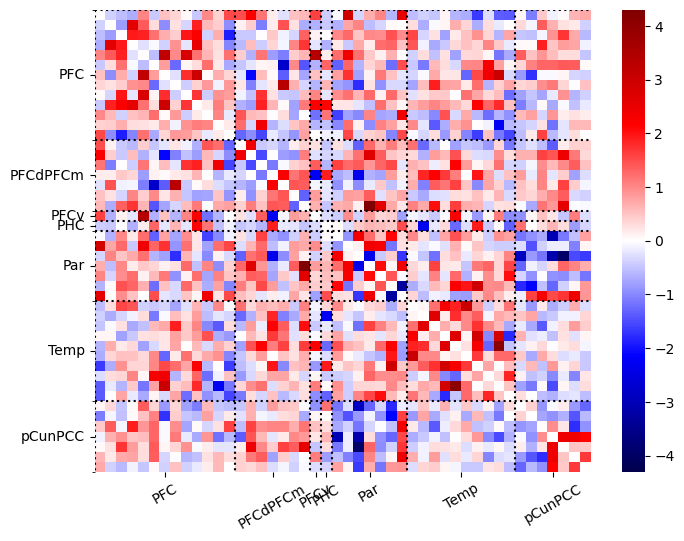

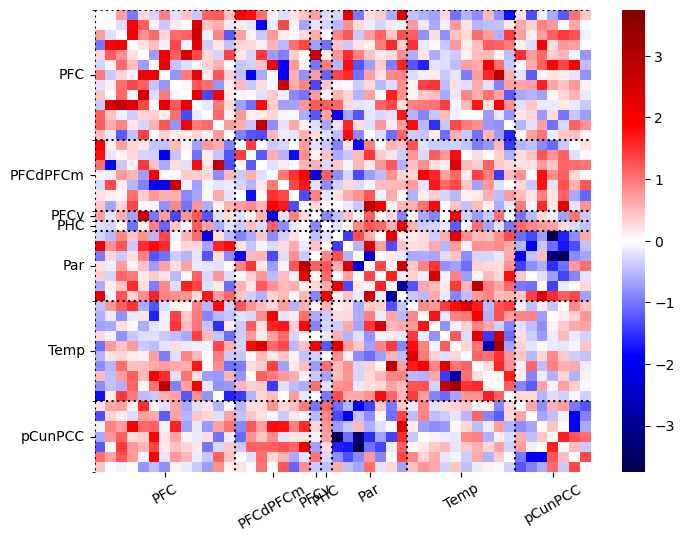

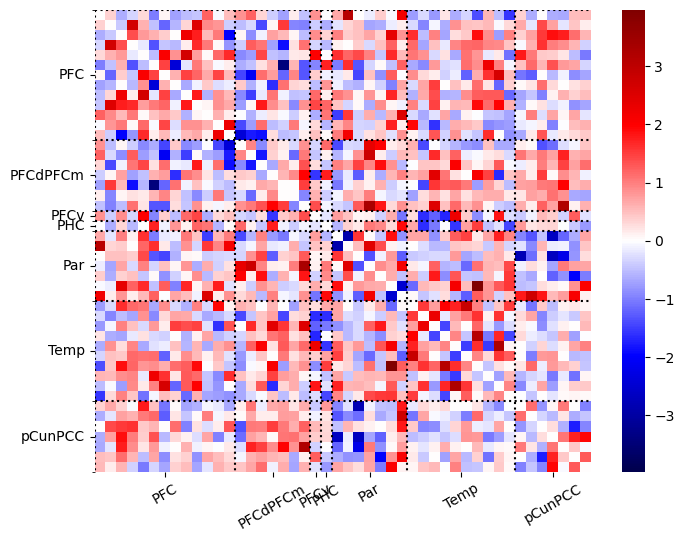

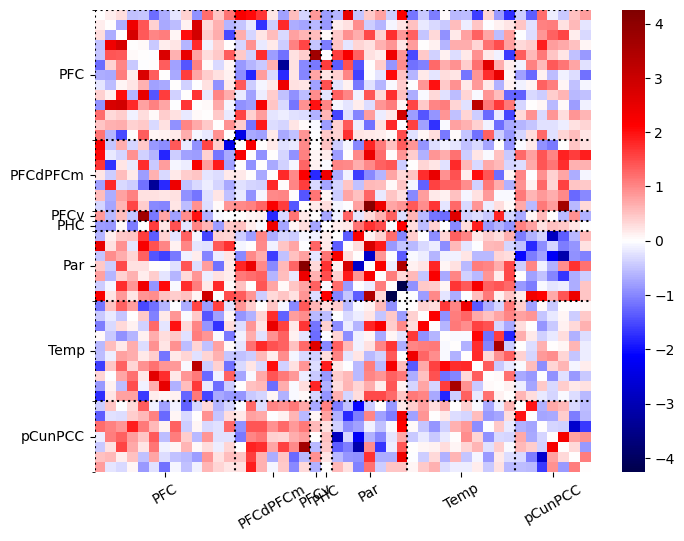

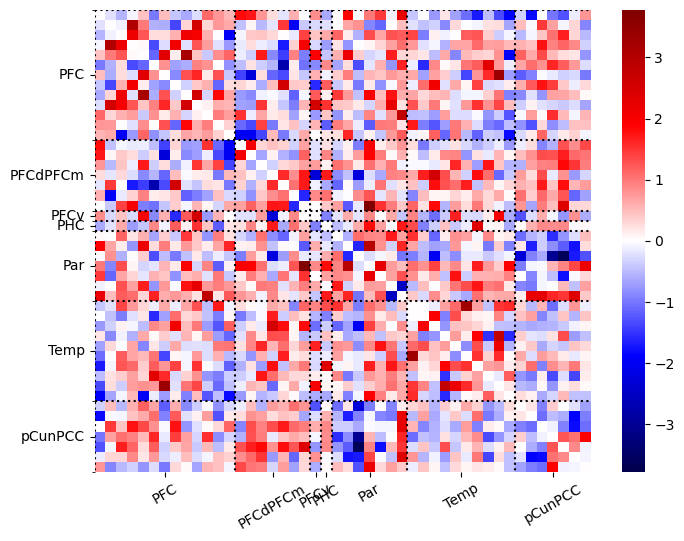

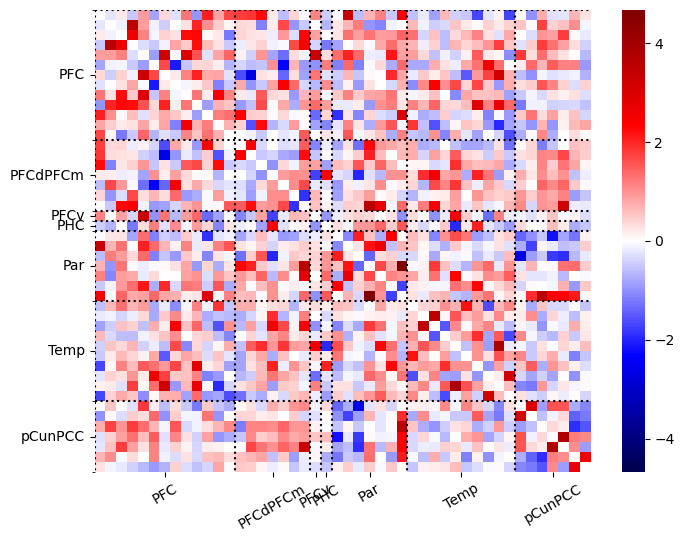

In [10]:
for mat in hmat:
    plot_matrix(mat[0], disp_atlas)
    plt.show()

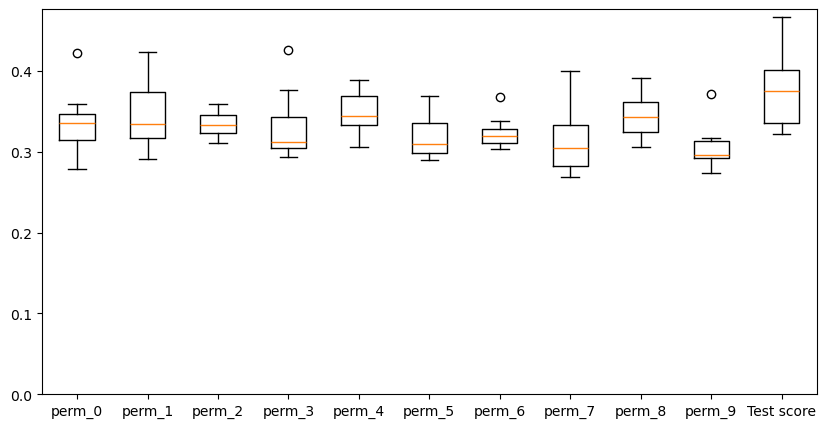

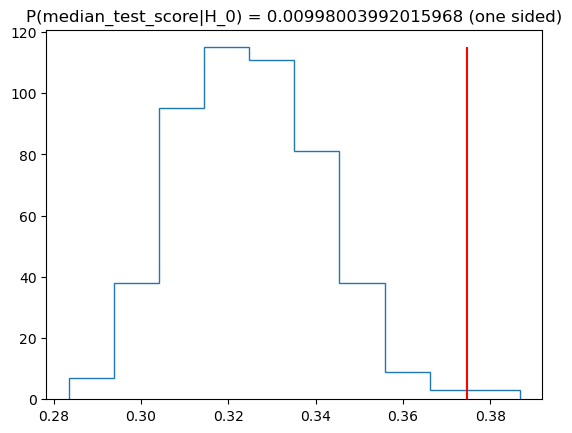

In [11]:
import random

N = 500
p = Path("/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-schaefer200_net-Default_inter-Default")
perm_res = joblib.load(p / f"{N}_permutations_res.joblib")
permscores = [pr[0] for pr in perm_res]
permweights = [pr[1] for pr in perm_res]

disp_sample = random.sample(permscores, k=10)
disp_sample.append(test_scores)

labels = [f"perm_{i}" for i in range(10)]
labels.append("Test score")

plt.subplots(figsize=(10, 5))
plt.boxplot(disp_sample, labels=labels)
plt.ylim(0)
plt.show()

median_scores = tuple(map(np.median, permscores))
median_test = np.median(test_scores)
pvalue = (1 + np.sum(median_test < median_scores)) / (1 + N)

h = plt.hist(median_scores, histtype="step")
plt.vlines(median_test, ymin=0, ymax=np.max(h[0]), color="red")
plt.title(f"P(median_test_score|H_0) = {pvalue} (one sided)")
plt.show()

In [12]:
from nilearn.connectome import vec_to_sym_matrix
n_classes = k
n_regions = int(np.sqrt(masker.topology_.sum()))
median_maps = []

# TODO Mean or median?
for pm in permweights:
    median_weights = np.mean(pm, axis=0)
    median_map = vec_to_sym_matrix(
        median_weights.transpose((1, 0)), diagonal=np.zeros((n_classes, n_regions))
    )
    median_maps.append(median_map)

median_maps = np.stack(median_maps, axis=0)

realised_mm = np.mean(hmat, axis=0)

In [13]:
mean_patterns = np.mean(patterns, axis=0)
ranks = np.argsort(np.abs(mean_patterns), axis=0)[::-1]

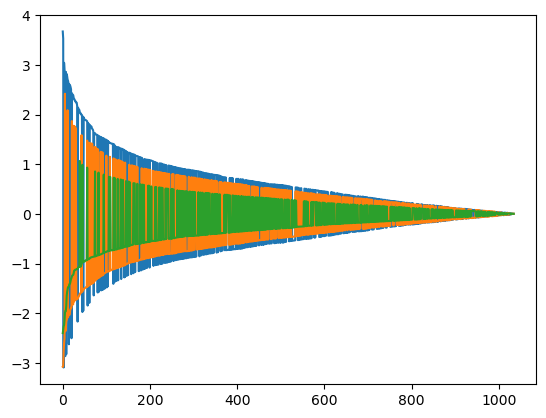

In [14]:
sorted_patterns = np.take_along_axis(mean_patterns, ranks, axis=0)
plt.plot(
    sorted_patterns
)
plt.show()

In [15]:
# TODO Try single step max T? More permutations? Min vs max? It's a weird way to control
# for significativity since in one direction, perhaps the effect is less pronounced
# That's also the point of permutations isn't it?
m = patterns.shape[1]
u = np.zeros((m, N))

for b, pm in enumerate(permweights):
    
    t_perm = np.mean(pm, axis=0)[:, 0]
    r_m = ranks[-1, 0]
    
    u[-1, b] = abs(t_perm[r_m])

    for j in range(m - 2, -1, -1):
        r_j = ranks[j, 0]
        u[j, b] = max(
            u[j+1, b],
            abs(t_perm[r_j])
        )

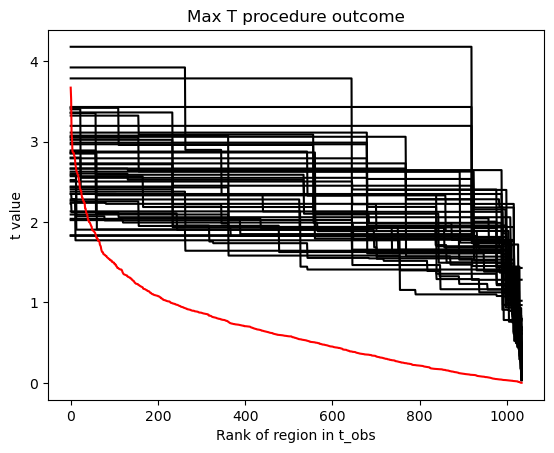

In [16]:
for b in range(0, 500, 10):
    plt.plot(u[:, b], color="black")

plt.plot(np.abs(sorted_patterns)[:, 0], color="red")
plt.title("Max T procedure outcome")
plt.ylabel("t value")
plt.xlabel("Rank of region in t_obs")
plt.show()

In [17]:
msk = mean_patterns[:, 0].reshape((-1, 1)) <= u
pwest = np.sum(msk, axis=1) / N

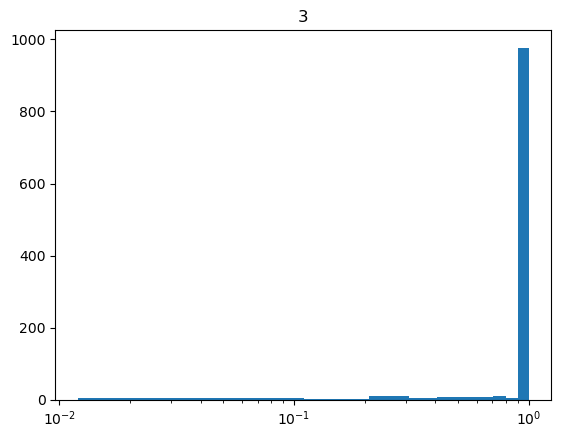

In [19]:
plt.hist(pwest)
plt.xscale("log")
plt.title(np.sum(pwest < 0.05))
plt.show()

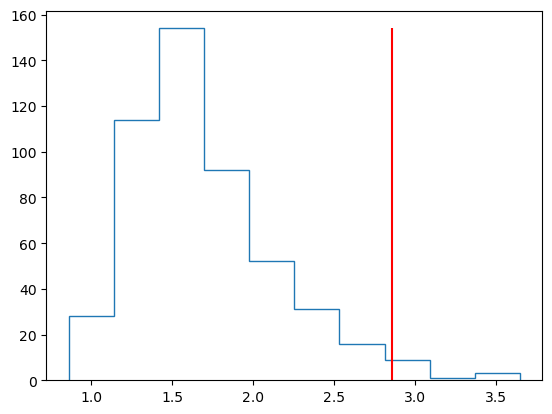

In [20]:
idx = np.where(pwest < 0.05)[0][2]
h = plt.hist(u[idx, :].flatten(), histtype="step")
plt.vlines(mean_patterns[idx, 0], ymin=0, ymax=np.max(h[0]), color="red")
plt.show()

In [30]:
pvalues_more = np.sum(realised_mm > median_maps, axis=0) / N
pvalues_less = np.sum(realised_mm < median_maps, axis=0) / N
pvalues = np.minimum(pvalues_less, pvalues_more) * 2

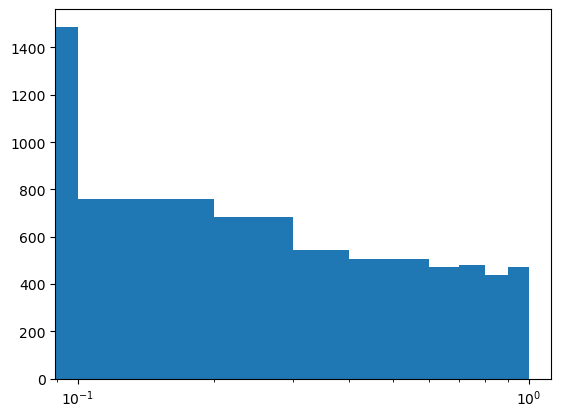

In [31]:
plt.hist(pvalues.flatten())
plt.xscale("log")
plt.show()

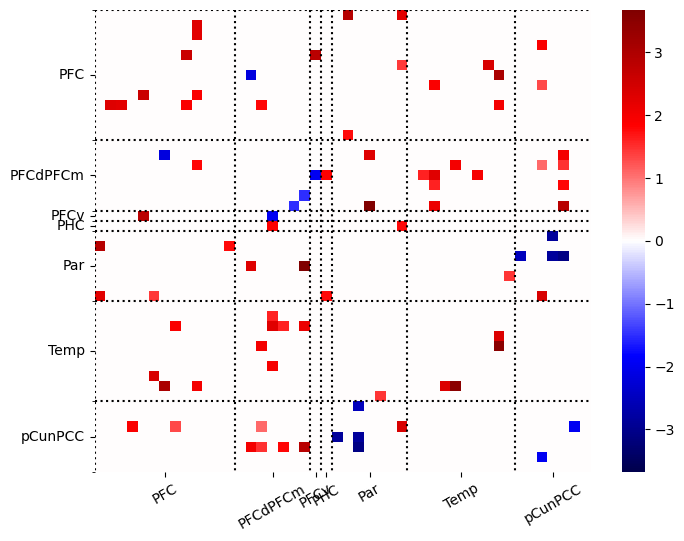

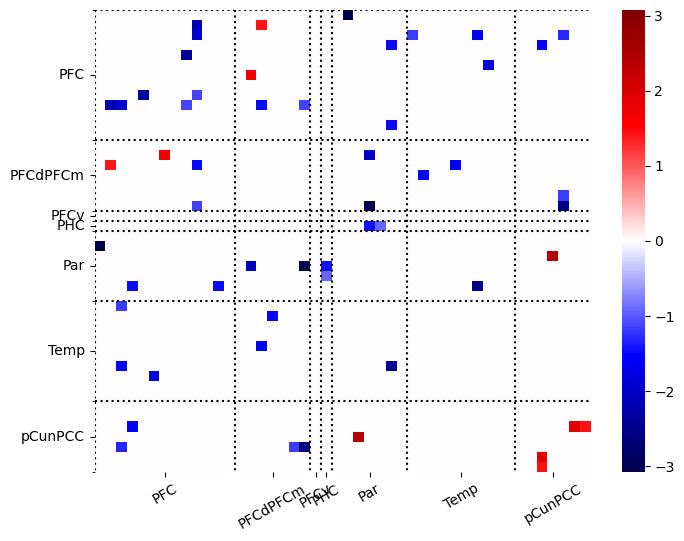

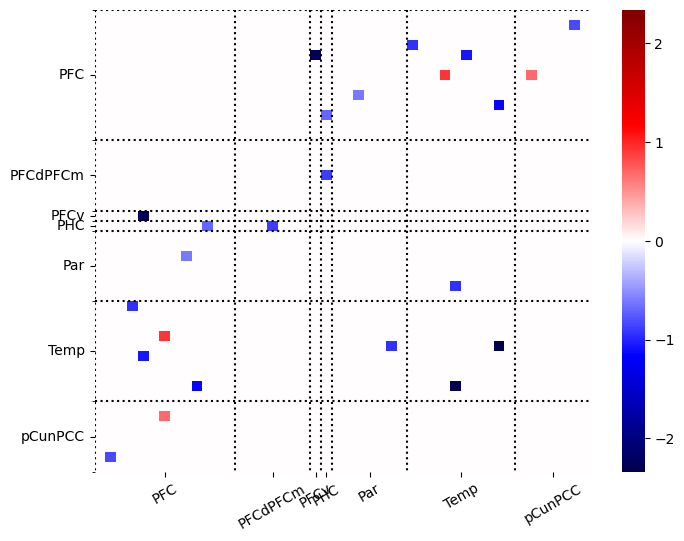

In [32]:
# Reproject to the brain?
# Try max t min p
thresh_map = np.where(pvalues < (0.05 / 1035), realised_mm, 0)
plot_matrix(thresh_map[0], disp_atlas)
plt.show()
plot_matrix(thresh_map[1], disp_atlas)
plt.show()
plot_matrix(thresh_map[2], disp_atlas)
plt.show()

In [ ]:
import joblib
joblib.dump(test_scores, run_path / "test_scores.joblib")
joblib.dump(clf, run_path / "best_estimator.joblib")

['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-schaefer200_net-all/best_estimator.joblib']